In [1]:
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import h5py
import scipy.stats
import random
from matplotlib.pyplot import *
from statsmodels.nonparametric import smoothers_lowess
import statsmodels.stats.multitest
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import glob

sns.set_style("ticks")
%matplotlib inline

In [3]:
mydir = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_neuroseq/data/data_processed/"

In [4]:
fraction_file_dict = {'D11':mydir+'pool1_13_noddd_D11/pool1_13_noddd_D11.scanpy.w_metadata.w_celltype.scanpy.obs_df.groupedby.donor_id-pool_id-time_point.celltype_fractions.tsv',
                     'D30':mydir+'pool1_13_noddd_D30/pool1_13_noddd_D30.scanpy.w_metadata.w_celltype.scanpy.obs_df.groupedby.donor_id-pool_id-time_point.celltype_fractions.tsv',
                     'D52':mydir+'pool1_17_D52/pool1_17_D52.scanpy.w_metadata.w_celltype.scanpy.obs_df.groupedby.donor_id-pool_id-time_point.celltype_fractions.tsv'}


timepoints = ['D11','D30','D52']

cell_threshold = 10

list_of_dfs = []
for timepoint in timepoints:
    fraction_file = fraction_file_dict[timepoint]
    count_file = fraction_file.replace('fractions','counts')
    frac_df = pd.read_csv(fraction_file, sep='\t')
    count_df = pd.read_csv(count_file, sep='\t')

    frac_df['donor_pool_label'] = frac_df['donor_id'] + ':' + frac_df['pool_id']
    count_df['donor_pool_label'] = count_df['donor_id'] + ':' + count_df['pool_id']
    donor_pool_counts = count_df.groupby('donor_pool_label').sum()
    selected_donor_pools = donor_pool_counts[donor_pool_counts['n_cells']>=cell_threshold].index
    frac_df = frac_df.query('donor_pool_label in @selected_donor_pools')
    
    frac_df['label'] = frac_df['celltype'] + '_' + frac_df['time_point'].astype(str)
    df = frac_df.set_index(['donor_id','pool_id'])[['label','f_cells']]
    df = df.pivot(columns='label')

    df.columns = df.columns.get_level_values(1)

    # fill 0 for any fraction that didn't have any cells in it
    df = df.fillna(0.0)
    print(df.shape)
    list_of_dfs.append(df)

# drop nas so we have a set of complete trajectories
df2 = pd.concat(list_of_dfs, axis=1)


print(df2.shape)
df2.head()

(197, 3)
(199, 7)
(227, 10)
(251, 20)


label                      FPP_D11    NB_D11  P_FPP_D11  Astro_D30  CHem_D30  \
donor_id         pool_id                                                       
HPSI0114i-bezi_3 pool10        NaN       NaN        NaN   0.215278  0.038194   
HPSI0114i-eipl_1 pool1    0.536413  0.073147   0.390440   0.298340  0.333462   
HPSI0114i-fikt_3 pool14        NaN       NaN        NaN        NaN       NaN   
HPSI0114i-kolf_2 pool10        NaN       NaN        NaN   0.133333  0.000000   
                 pool12   0.618519  0.029630   0.351852   0.121569  0.027451   

label                       DA_D30  Epen1_D30  P_FPP_D30  Sert_D30  \
donor_id         pool_id                                             
HPSI0114i-bezi_3 pool10   0.399306   0.072917   0.045139  0.229167   
HPSI0114i-eipl_1 pool1    0.019684   0.253570   0.044384  0.005403   
HPSI0114i-fikt_3 pool14        NaN        NaN        NaN       NaN   
HPSI0114i-kolf_2 pool10   0.558333   0.100000   0.058333  0.150000   
                 pool12   0.713725   0.054902   0.054902  0.027451   

label                     unknown_D30  Astro_D52  CHem_D52    DA_D52  \
donor_id         pool_id                                               
HPSI0114i-bezi_3 pool10      0.000000   0.015267  0.015267  0.262087   
HPSI0114i-eipl_1 pool1       0.045156   0.511934  0.090457  0.009562   
HPSI0114i-fikt_3 pool14           NaN   0.116608  0.014134  0.236749   
HPSI0114i-kolf_2 pool10      0.000000   0.004115  0.000000  0.213992   
                 pool12      0.000000        NaN       NaN       NaN   

label                     Epen1_D52  Epen2_D52   FPP_D52  P_FPP_D52  \
donor_id         pool_id                                              
HPSI0114i-bezi_3 pool10    0.201018   0.000000  0.162850   0.010178   
HPSI0114i-eipl_1 pool1     0.138153   0.003085  0.157895   0.079699   
HPSI0114i-fikt_3 pool14    0.219081   0.014134  0.166078   0.021201   
HPSI0114i-kolf_2 pool10    0.320988   0.037037  0.098765   0.000000   
                 pool12         NaN        NaN       NaN        NaN   

label                     P_Sert_D52  Sert_D52  unknown_D52  
donor_id         pool_id                                     
HPSI0114i-bezi_3 pool10     0.012723  0.320611     0.000000  
HPSI0114i-eipl_1 pool1      0.000193  0.003316     0.005707  
HPSI0114i-fikt_3 pool14     0.000000  0.166078     0.045936  
HPSI0114i-kolf_2 pool10     0.004115  0.288066     0.032922  
                 pool12          NaN       NaN          NaN

In [5]:
df.reset_index()['pool_id'].drop_duplicates()

0     pool10
1      pool1
2     pool14
4     pool15
6     pool17
10     pool6
11     pool7
13     pool4
14     pool8
18     pool2
20     pool3
21     pool5
31     pool9
44    pool16
64    pool11
87    pool13
Name: pool_id, dtype: object

In [6]:
df2['diff_efficiency'] = df2[['DA_D52','Sert_D52']].sum(axis=1,skipna=False)

df3 = df2[['diff_efficiency']].dropna().reset_index()

(df3['donor_id'].value_counts()>=2).sum()

31

In [7]:
# calculate averages for each pool, in order to correct for this later
pool_averages = df2.reset_index().groupby('pool_id').mean()
pool_averages.head()

label,FPP_D11,NB_D11,P_FPP_D11,Astro_D30,CHem_D30,DA_D30,Epen1_D30,P_FPP_D30,Sert_D30,unknown_D30,...,CHem_D52,DA_D52,Epen1_D52,Epen2_D52,FPP_D52,P_FPP_D52,P_Sert_D52,Sert_D52,unknown_D52,diff_efficiency
pool_id,,,,,,,,,,,,,,,,,,,,,
pool1,0.579637,0.014688,0.405675,0.128498,0.076055,0.453692,0.052032,0.047491,0.233383,0.008850,...,0.045784,0.195719,0.102894,0.004458,0.140749,0.041205,0.004404,0.300049,0.024602,0.495768
pool10,NaN,NaN,NaN,0.168847,0.044217,0.436889,0.110513,0.050692,0.187279,0.001564,...,0.021553,0.278479,0.216101,0.009834,0.132560,0.032036,0.006110,0.218579,0.012969,0.497058
pool11,0.320348,0.035650,0.644003,0.137218,0.055833,0.496364,0.080460,0.055732,0.172918,0.001475,...,0.056691,0.360122,0.082752,0.003088,0.094827,0.029364,0.004383,0.273988,0.012853,0.634110
pool12,0.609019,0.024115,0.366866,0.123020,0.029639,0.539848,0.035518,0.145531,0.125183,0.001262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pool13,0.506876,0.029003,0.464120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.021353,0.183824,0.241636,0.007087,0.085706,0.033696,0.007963,0.315713,0.014420,0.499537


In [11]:
def make_plot(cluster_label, name):

    df5 = df2[cluster_label].dropna().reset_index()
    df5.columns = ['donor_id','pool_id','f_cells']

    df5['f_cells_corrected'] = df5.apply(lambda x: x.loc['f_cells'] - pool_averages.loc[x.loc['pool_id'],cluster_label],
                                                     axis=1)

    donor_counts = df5['donor_id'].value_counts()
    selected_donors = donor_counts[donor_counts==2].index

    df5 = df5.query('donor_id in @selected_donors').set_index('donor_id')

    x_data = []
    y_data = []
    for donor in selected_donors:
        data = df5.loc[donor, 'f_cells']
        x_data.append(data.iloc[0])
        y_data.append(data.iloc[1])

    fig = figure(figsize=(4.5,4))
    FS = 18

    # plot([0.0,1.0],[0.0,1.0],'k--')
#     plot(x_data,y_data,'o',color='k')
    sns.regplot(x=x_data, y=y_data, color='k')
    R,p = scipy.stats.pearsonr(x_data,y_data)
    text(0.05,0.85,s='R={:.2f}'.format(R),fontsize=24)
    if p<0.01:
        text(0.05,0.75,s='p={:.0e}'.format(p),fontsize=FS)
    else:
        text(0.05,0.75,s='p={:.2f}'.format(p),fontsize=FS)

    print(R,p,R*R)
    xlim([0,1.0])
    ylim([0,1.0])
    xlabel('{}\n(replicate 1)'.format(name), fontsize=FS)
    ylabel('{}\n(replicate 2)'.format(name), fontsize=FS)

    print('')

0.7452233631833556 2.308873751624224e-06 0.5553578610343115



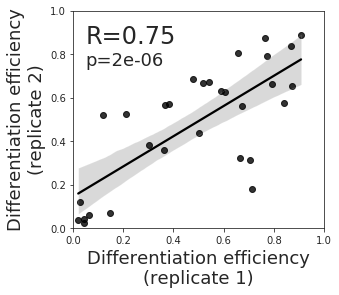

In [12]:

cluster_label,name = 'diff_efficiency','Differentiation efficiency'
# cluster_label,name = 'Sert_D52','Sert'

#cluster_label_name_list = [('diff_efficiency','Differentiation efficiency')]
cluster_label_name_list = [('diff_efficiency','Differentiation efficiency')]

#cluster_label_name_list = [(x,'Proportion of {} cells\n(Day {})'.format(x.split('_D')[0], x.split('_')[-1])) for x in df2.columns if x!='diff_efficiency']

for cluster_label, name in cluster_label_name_list:
    make_plot(cluster_label, name)